# IMDB Sentiment Analysis with Naive Bayes and Other Classifiers

This notebook demonstrates sentiment analysis on the IMDB movie review dataset using various classifiers, including a custom Naive Bayes implementation, Scikit-learn's Naive Bayes, Logistic Regression, and MLP.

Development data results:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2437
           1       0.87      0.86      0.86      2563

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000


Test data results:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     12500
           1       0.87      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



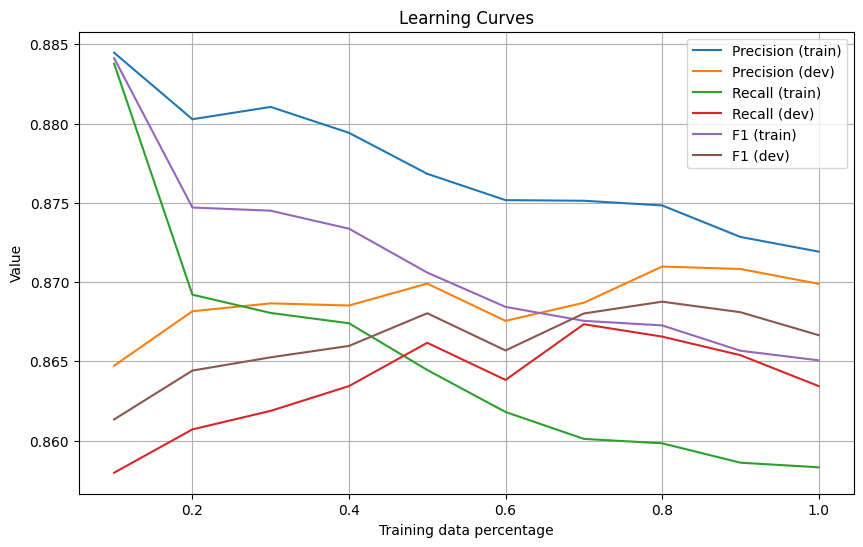

Scikit-learn Naive Bayes Development data results:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2437
           1       0.84      0.88      0.86      2563

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000


Scikit-learn Naive Bayes Test data results:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84     12500
           1       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Logistic Regression Development data results:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2437
           1       0.87      0.88      0.87      2563

    accuracy                           0

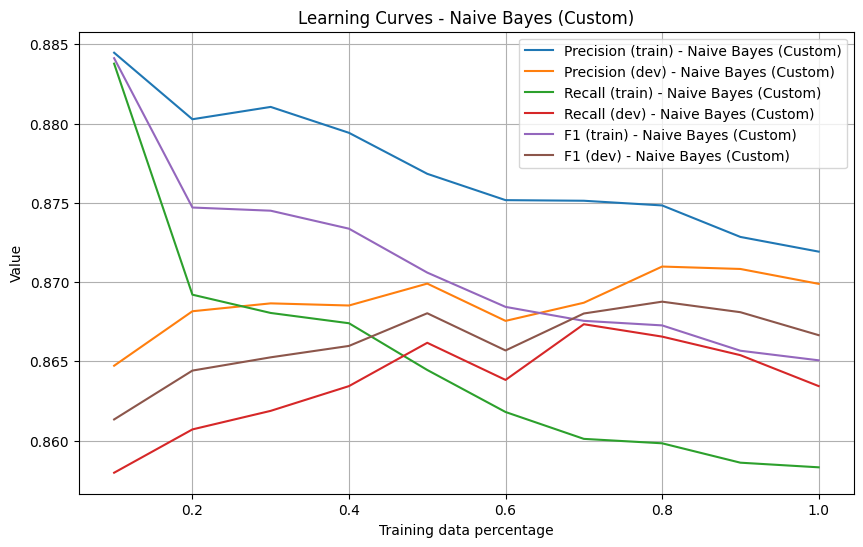

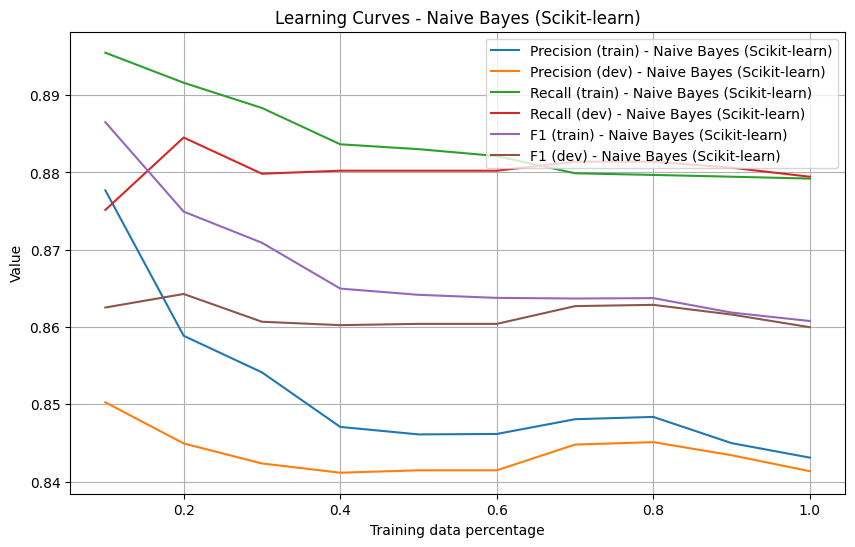

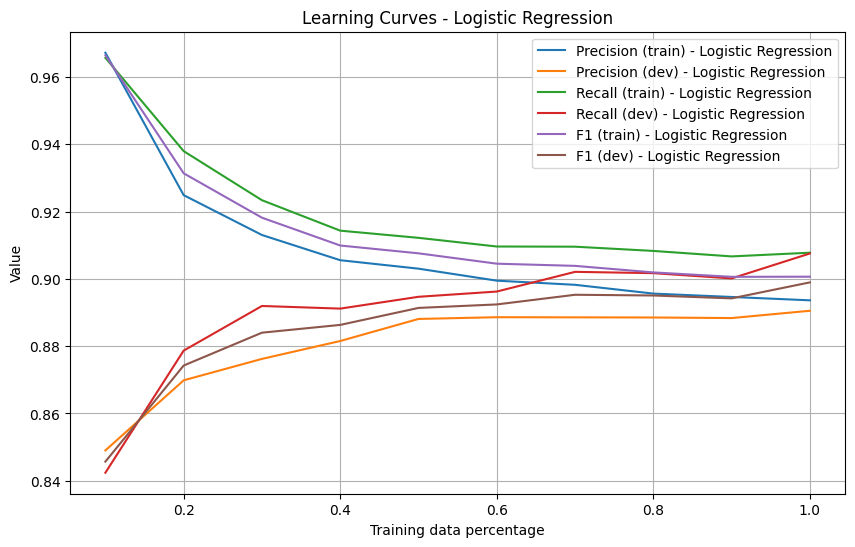

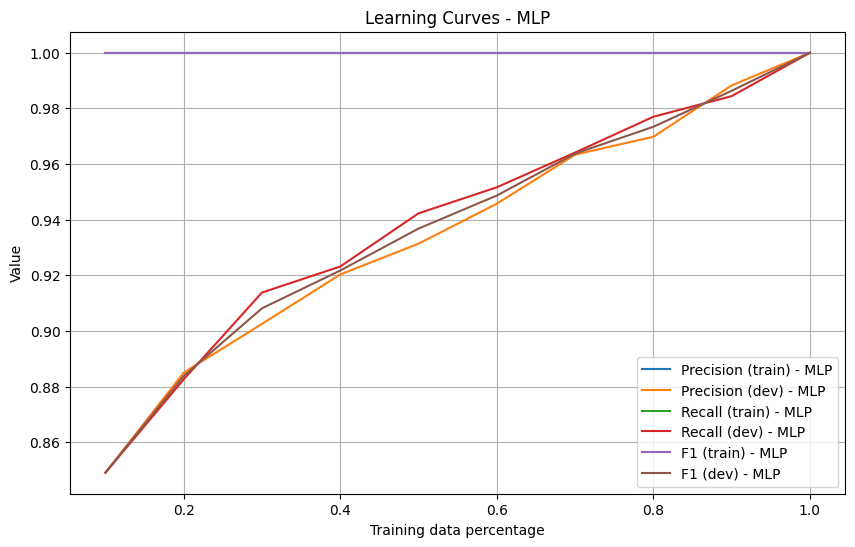

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from math import log

# Υπερπαράμετροι
n = 20  # Αριθμός πιο συχνών λέξεων που θα παραλειφθούν
k = 20  # Αριθμός πιο σπάνιων λέξεων που θα παραλειφθούν
m = 1000  # Μέγεθος λεξιλογίου
dev_size = 0.2  # Ποσοστό δεδομένων εκπαίδευσης για δεδομένα ανάπτυξης

# Φόρτωση IMDB dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=None, skip_top=0)
word_index = tf.keras.datasets.imdb.get_word_index()

# Αποκωδικοποίηση δεικτών σε λέξεις
def decode_review(encoded_review, index2word):
    return ' '.join([index2word.get(idx, '?') for idx in encoded_review])

index2word = {i + 3: word for word, i in word_index.items()}
index2word.update({0: '[pad]', 1: '[bos]', 2: '[oov]'})

x_train = np.array([decode_review(review, index2word) for review in x_train])
x_test = np.array([decode_review(review, index2word) for review in x_test])

# Δημιουργία μετρητή λέξεων
vectorizer = CountVectorizer(max_features=None, stop_words=None, binary=True)
X_train = vectorizer.fit_transform(x_train).toarray()
X_test = vectorizer.transform(x_test).toarray()

# Αφαίρεση πιο συχνών και πιο σπάνιων λέξεων
word_counts = np.sum(X_train, axis=0)
indices = np.argsort(word_counts)
vocabulary = vectorizer.get_feature_names_out()
vocabulary = np.delete(vocabulary, np.concatenate((indices[:k], indices[-n:])))

def information_gain(X, y, feature_index):
    total_entropy = entropy(y)
    feature_values = X[:, feature_index]
    unique_values = np.unique(feature_values)
    weighted_entropy = 0
    for value in unique_values:
        subset_y = y[feature_values == value]
        weighted_entropy += len(subset_y) / len(y) * entropy(subset_y)
    return total_entropy - weighted_entropy

def entropy(y):
    probabilities = np.bincount(y) / len(y)
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Υπολογισμός πληροφοριακού κέρδους για κάθε λέξη
gains = [information_gain(X_train, y_train, i) for i in range(X_train.shape[1])]
indices = np.argsort(gains)[-m:]
vocabulary = vectorizer.get_feature_names_out()[indices]

# Δημιουργία νέου μετρητή λέξεων με το επιλεγμένο λεξιλόγιο
vectorizer = CountVectorizer(vocabulary=vocabulary, binary=True)
X_train = vectorizer.fit_transform(x_train).toarray()
X_test = vectorizer.transform(x_test).toarray()

class NaiveBayes:
    def fit(self, X, y, alpha=1):
        self.classes = np.unique(y)
        self.priors = {c: np.mean(y == c) for c in self.classes}
        self.likelihoods = {}
        for c in self.classes:
            X_c = X[y == c]
            self.likelihoods[c] = (np.sum(X_c, axis=0) + alpha) / (np.sum(X_c) + alpha * X.shape[1])

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                prior = self.priors[c]
                likelihood = np.prod(self.likelihoods[c] ** x * (1 - self.likelihoods[c]) ** (1 - x))
                posterior = prior * likelihood
                posteriors[c] = posterior
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)

# Διαχωρισμός δεδομένων εκπαίδευσης σε εκπαίδευση και ανάπτυξη
X_train_split, X_dev, y_train_split, y_dev = train_test_split(X_train, y_train, test_size=dev_size, random_state=42)

# Εκπαίδευση ταξινομητή
nb = NaiveBayes()
nb.fit(X_train_split, y_train_split)

# Προβλέψεις στα δεδομένα ανάπτυξης
y_dev_pred = nb.predict(X_dev)

# Αξιολόγηση απόδοσης
print("Development data results:")
print(classification_report(y_dev, y_dev_pred))

# Εκπαίδευση με όλα τα δεδομένα εκπαίδευσης
nb.fit(X_train, y_train)

# Προβλέψεις στα δεδομένα ελέγχου
y_test_pred = nb.predict(X_test)

# Αξιολόγηση απόδοσης
print("\nTest data results:")
print(classification_report(y_test, y_test_pred))

# Καμπύλες μάθησης
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
dev_scores = []

for size in train_sizes:
    train_size = int(len(X_train) * size)
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]

    nb.fit(X_train_subset, y_train_subset)

    y_train_pred = nb.predict(X_train_subset)
    y_dev_pred = nb.predict(X_dev)

    train_scores.append(precision_recall_fscore_support(y_train_subset, y_train_pred, average='binary'))
    dev_scores.append(precision_recall_fscore_support(y_dev, y_dev_pred, average='binary'))

# Δημιουργία γραφημάτων
train_precision = [s[0] for s in train_scores]
train_recall = [s[1] for s in train_scores]
train_f1 = [s[2] for s in train_scores]

dev_precision = [s[0] for s in dev_scores]
dev_recall = [s[1] for s in dev_scores]
dev_f1 = [s[2] for s in dev_scores]

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_precision, label='Precision (train)')
plt.plot(train_sizes, dev_precision, label='Precision (dev)')
plt.plot(train_sizes, train_recall, label='Recall (train)')
plt.plot(train_sizes, dev_recall, label='Recall (dev)')
plt.plot(train_sizes, train_f1, label='F1 (train)')
plt.plot(train_sizes, dev_f1, label='F1 (dev)')
plt.xlabel('Training data percentage')
plt.ylabel('Value')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

# sugkriseis #

from sklearn.naive_bayes import BernoulliNB
# Εκπαίδευση του Naive Bayes του Scikit-learn
sk_nb = BernoulliNB(alpha=1)
sk_nb.fit(X_train_split, y_train_split)

# Προβλέψεις στα δεδομένα ανάπτυξης
y_dev_pred_sk = sk_nb.predict(X_dev)

# Αξιολόγηση απόδοσης
print("Scikit-learn Naive Bayes Development data results:")
print(classification_report(y_dev, y_dev_pred_sk))

# Προβλέψεις στα δεδομένα ελέγχου
y_test_pred_sk = sk_nb.predict(X_test)

# Αξιολόγηση απόδοσης
print("\nScikit-learn Naive Bayes Test data results:")
print(classification_report(y_test, y_test_pred_sk))

from sklearn.linear_model import LogisticRegression

# Εκπαίδευση του Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_split, y_train_split)

# Προβλέψεις στα δεδομένα ανάπτυξης
y_dev_pred_lr = lr.predict(X_dev)

# Αξιολόγηση απόδοσης
print("Logistic Regression Development data results:")
print(classification_report(y_dev, y_dev_pred_lr))

# Προβλέψεις στα δεδομένα ελέγχου
y_test_pred_lr = lr.predict(X_test)

# Αξιολόγηση απόδοσης
print("\nLogistic Regression Test data results:")
print(classification_report(y_test, y_test_pred_lr))

from sklearn.neural_network import MLPClassifier

# Εκπαίδευση του MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp.fit(X_train_split, y_train_split)

# Προβλέψεις στα δεδομένα ανάπτυξης
y_dev_pred_mlp = mlp.predict(X_dev)

# Αξιολόγηση απόδοσης
print("MLP Development data results:")
print(classification_report(y_dev, y_dev_pred_mlp))

# Προβλέψεις στα δεδομένα ελέγχου
y_test_pred_mlp = mlp.predict(X_test)

# Αξιολόγηση απόδοσης
print("\nMLP Test data results:")
print(classification_report(y_test, y_test_pred_mlp))

# Καμπύλες μάθησης για Naive Bayes (δική μας υλοποίηση)
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores_nb = []
dev_scores_nb = []

for size in train_sizes:
    train_size = int(len(X_train) * size)
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]

    nb.fit(X_train_subset, y_train_subset)

    y_train_pred = nb.predict(X_train_subset)
    y_dev_pred = nb.predict(X_dev)

    train_scores_nb.append(precision_recall_fscore_support(y_train_subset, y_train_pred, average='binary'))
    dev_scores_nb.append(precision_recall_fscore_support(y_dev, y_dev_pred, average='binary'))

# Καμπύλες μάθησης για Naive Bayes (Scikit-learn)
train_scores_sk_nb = []
dev_scores_sk_nb = []

for size in train_sizes:
    train_size = int(len(X_train) * size)
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]

    sk_nb.fit(X_train_subset, y_train_subset)

    y_train_pred = sk_nb.predict(X_train_subset)
    y_dev_pred = sk_nb.predict(X_dev)

    train_scores_sk_nb.append(precision_recall_fscore_support(y_train_subset, y_train_pred, average='binary'))
    dev_scores_sk_nb.append(precision_recall_fscore_support(y_dev, y_dev_pred, average='binary'))

# Καμπύλες μάθησης για Logistic Regression
train_scores_lr = []
dev_scores_lr = []

for size in train_sizes:
    train_size = int(len(X_train) * size)
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]

    lr.fit(X_train_subset, y_train_subset)

    y_train_pred = lr.predict(X_train_subset)
    y_dev_pred = lr.predict(X_dev)

    train_scores_lr.append(precision_recall_fscore_support(y_train_subset, y_train_pred, average='binary'))
    dev_scores_lr.append(precision_recall_fscore_support(y_dev, y_dev_pred, average='binary'))

# Καμπύλες μάθησης για MLP
train_scores_mlp = []
dev_scores_mlp = []

for size in train_sizes:
    train_size = int(len(X_train) * size)
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]

    mlp.fit(X_train_subset, y_train_subset)

    y_train_pred = mlp.predict(X_train_subset)
    y_dev_pred = mlp.predict(X_dev)

    train_scores_mlp.append(precision_recall_fscore_support(y_train_subset, y_train_pred, average='binary'))
    dev_scores_mlp.append(precision_recall_fscore_support(y_dev, y_dev_pred, average='binary'))

# Δημιουργία γραφημάτων
def plot_learning_curves(train_scores, dev_scores, label):
    train_precision = [s[0] for s in train_scores]
    train_recall = [s[1] for s in train_scores]
    train_f1 = [s[2] for s in train_scores]

    dev_precision = [s[0] for s in dev_scores]
    dev_recall = [s[1] for s in dev_scores]
    dev_f1 = [s[2] for s in dev_scores]

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_precision, label=f'Precision (train) - {label}')
    plt.plot(train_sizes, dev_precision, label=f'Precision (dev) - {label}')
    plt.plot(train_sizes, train_recall, label=f'Recall (train) - {label}')
    plt.plot(train_sizes, dev_recall, label=f'Recall (dev) - {label}')
    plt.plot(train_sizes, train_f1, label=f'F1 (train) - {label}')
    plt.plot(train_sizes, dev_f1, label=f'F1 (dev) - {label}')
    plt.xlabel('Training data percentage')
    plt.ylabel('Value')
    plt.title(f'Learning Curves - {label}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(train_scores_nb, dev_scores_nb, 'Naive Bayes (Custom)')
plot_learning_curves(train_scores_sk_nb, dev_scores_sk_nb, 'Naive Bayes (Scikit-learn)')
plot_learning_curves(train_scores_lr, dev_scores_lr, 'Logistic Regression')
plot_learning_curves(train_scores_mlp, dev_scores_mlp, 'MLP')